In [5]:
# !pip3 install nltk -qq
!pip3 install wordcloud -qq

In [6]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/diegobilhalva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython import display
import time

In [9]:
import os
from dotenv import load_dotenv

load_dotenv()

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = (
    SparkSession
    .builder
    .master('local[*]')
    .appName('WordCloud')
    .getOrCreate()
)

spark

23/01/19 13:51:50 WARN Utils: Your hostname, billy-virus resolves to a loopback address: 127.0.1.1; using 192.168.1.11 instead (on interface wlp0s20f3)
23/01/19 13:51:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/19 13:51:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [19]:
def trata_tweets(df):
    print(f'colunas: {df.columns}')
    words = (
        df
        .select(
            f.explode(f.split(f.lower('value'), ' ')).alias('word')
        )
        .withColumn('word', f.regexp_replace(f.col('word'), r'http\s+',''))
        .withColumn('word', f.regexp_replace(f.col('word'), r'@\w+',''))
        .withColumn('word', f.regexp_replace(f.col('word'), 'rt',''))
        .na.replace('',None)
        .na.drop()
    )
    return words

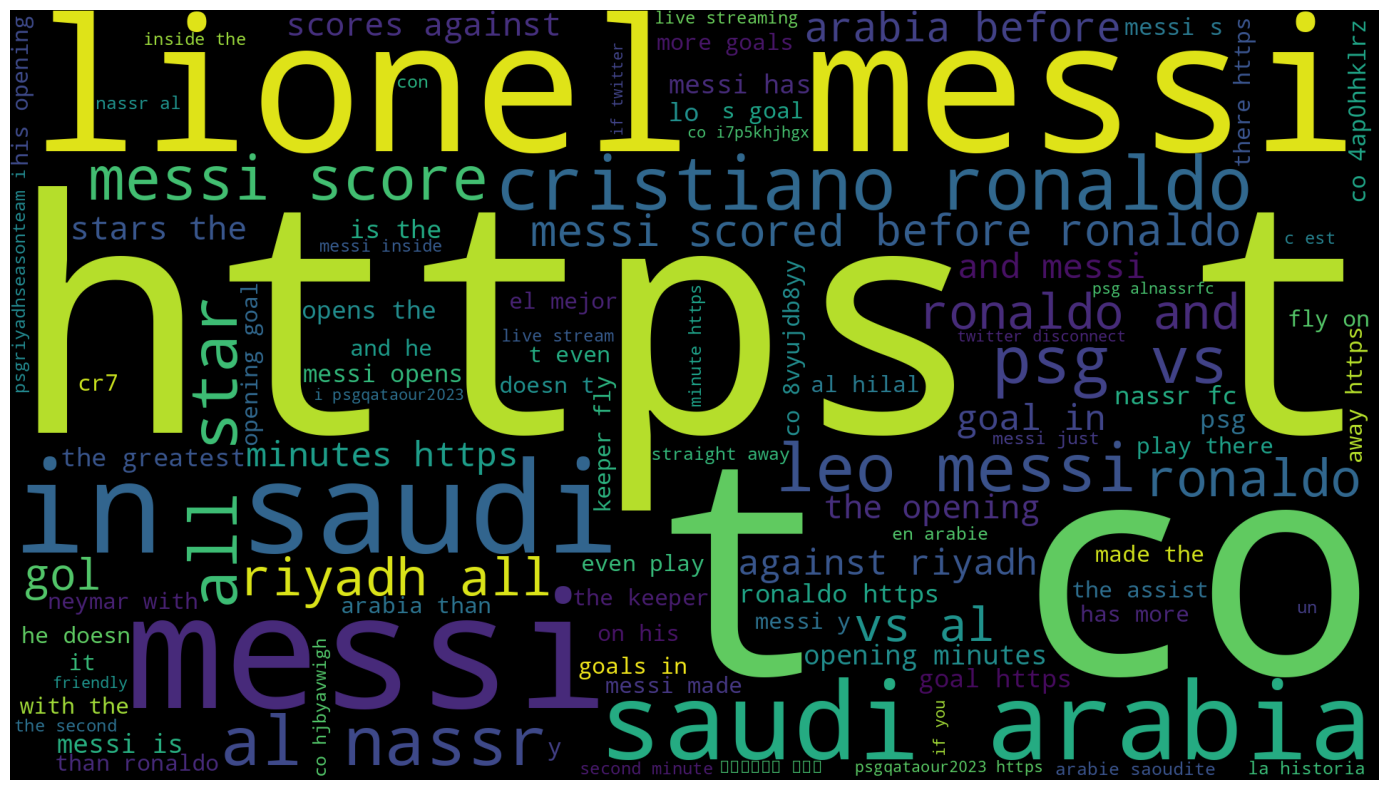

In [26]:
stops = (
    stopwords
    .words('portuguese')
)

stops.append('suarez')
plt.figure(figsize=(20,10))

while True:
    try:
        words = (
            spark.read.parquet('../parquet')
        )
        
        words = trata_tweets(words)
        rows = words.collect()
        all_words = ''
        for row in rows:
            all_words = all_words +' '+ row['word']
        
        wordcloud = WordCloud(
            stopwords=stops
            ,background_color='black'
            ,width=1920
            ,height=1080
            ,max_words=100
        ).generate(all_words)
        
        plt.cla()
        plt.axis('off')
        plt.imshow(wordcloud)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(5)
        
        
    except KeyboardInterrupt:
        break